# Example of using SAMS to calibrate TYR
Notebook to explore the calibration method of `protons` in implicit solvent. The aim is to see how the length of the simulations effects the convergence of SAMS weights, and to see the difference between repeats.

In [1]:
from __future__ import print_function
from simtk import unit, openmm
from simtk.openmm import app
from protons import AmberProtonDrive
from protons.calibration import SelfAdjustedMixtureSampling, AmberCalibrationSystem
import openmmtools
import numpy as np
from matplotlib import pylab as plt
%matplotlib inline

def get_data(path,folder):
    return os.path.join(PACKAGE_ROOT, folder, path)
class SystemSetup:
    """Empty class for storing systems and relevant attributes"""
    pass

## Instant swaps in implicit solvent

In [2]:
def load_tyrosine_implicit(directory, pH = 7.0, platform='CPU', nsteps=0, implicit=True):
    temperature = 300.0*unit.kelvin
    prmtop = app.AmberPrmtopFile(directory + 'tyr.prmtop')
    inpcrd = app.AmberInpcrdFile(directory + 'tyr.inpcrd')
    positions = inpcrd.getPositions()
    topology = prmtop.topology
    cpin_filename = directory + 'tyr.cpin'
    # Create system
    system = prmtop.createSystem(implicitSolvent=app.OBC2, nonbondedMethod=app.NoCutoff, constraints=app.HBonds)
    # Create protons integrator
    integrator = openmm.LangevinIntegrator(temperature, 1.0/unit.picoseconds, 2.0*unit.femtoseconds)
    # Create protons proton driver
    driver = AmberProtonDrive(system, temperature, pH, prmtop, cpin_filename, integrator, debug=False,
                              pressure=None, ncmc_steps_per_trial=nsteps, implicit=implicit)
    # Create SAMS sampler
    sams_sampler = SelfAdjustedMixtureSampling(driver)
    # Create simulation
    if platform == 'OpenCL':
        platform = openmm.Platform.getPlatformByName('OpenCL')
        properties = {'OpenCLPrecision': 'mixed'}
        simulation = app.Simulation(topology, system, driver.compound_integrator, platform, properties)
    else:
        simulation = app.Simulation(topology, system, driver.compound_integrator)
    simulation.context.setPositions(positions)
    simulation.context.setVelocitiesToTemperature(temperature)
    return simulation, driver, sams_sampler, integrator

In [3]:
directory = '/Users/rossg/Work/protons/protons/tests/testsystems/tyr_implicit/'

## Calibration 

Different parameters give different indications of convegence
* Example 1: 100 steps of MD per iteration
* Example 2: 100 steps of MD per iteration
* Example 3: 1000 steps of MD per iteration

#### Example 1
* 100 steps of MD per iteration

SAMS Weights = [ 0.         -4.88234214]


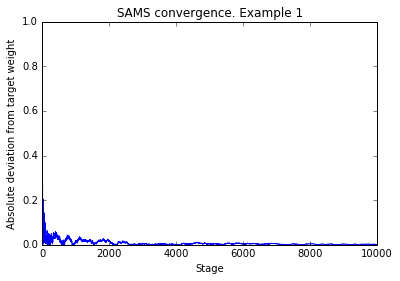

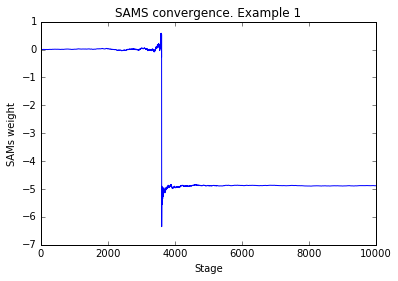

In [4]:
simulation, driver, sams_sampler, integrator = load_tyrosine_implicit(directory, platform='CPU')
simulation.minimizeEnergy(maxIterations=1000)

deviation = []    # The deviation between the target weight and actual counts
weights = []      # The bias applied by SAMS to reach target weight
N = 10000
for i in range(N):
    integrator.step(100)
    sams_sampler.driver.update(simulation.context)  # protonation
    deviation.append(sams_sampler.adapt_zetas(simulation.context, 'binary',end_of_burnin=5000))
    weights.append(sams_sampler.get_gk())
print('SAMS Weights =',sams_sampler.get_gk())

plt.plot(np.arange(N), deviation)
plt.xlabel('Stage')
plt.ylabel('Absolute deviation from target weight')
plt.title('SAMS convergence. Example 1')
plt.show()

g_k = [w[1] for w in weights]
plt.plot(np.arange(N), g_k)
plt.xlabel('Stage')
plt.ylabel('SAMs weight')
plt.title('SAMS convergence. Example 1')
plt.show()

#### Example 2
* Repeat of 100 steps of MD per iteration

SAMS Weights = [ 0.         -0.00542226]


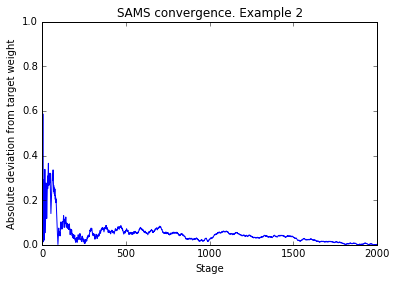

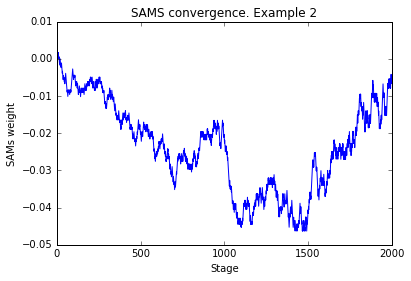

In [5]:
simulation, driver, sams_sampler, integrator = load_tyrosine_implicit(directory, platform='CPU')
simulation.minimizeEnergy(maxIterations=1000)

deviation = []    # The deviation between the target weight and actual counts
weights = []      # The bias applied by SAMS to reach target weight
N = 2000
for i in range(N):
    integrator.step(100)
    sams_sampler.driver.update(simulation.context)  # protonation
    deviation.append(sams_sampler.adapt_zetas(simulation.context, 'binary', end_of_burnin=5000))
    weights.append(sams_sampler.get_gk())
print('SAMS Weights =',sams_sampler.get_gk())

plt.clf()
plt.plot(np.arange(N), deviation)
plt.xlabel('Stage')
plt.ylabel('Absolute deviation from target weight')
plt.title('SAMS convergence. Example 2')
plt.show() 

g_k = [w[1] for w in weights]
plt.plot(np.arange(N), g_k)
plt.xlabel('Stage')
plt.ylabel('SAMs weight')
plt.title('SAMS convergence. Example 2')
plt.show()

#### Example 3
* 1000 steps of MD per iteration

SAMS Weights = [ 0.          0.00893596]


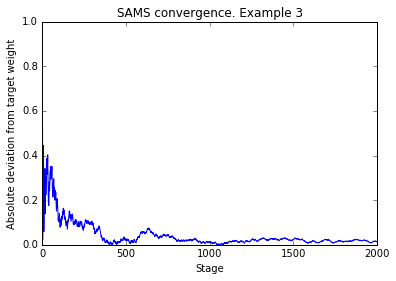

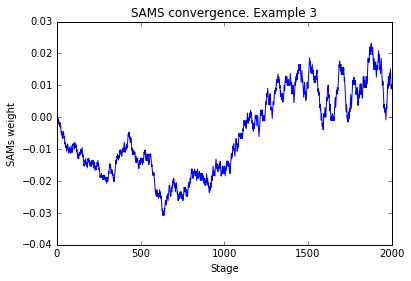

In [6]:
simulation, driver, sams_sampler, integrator = load_tyrosine_implicit(directory, platform='CPU')
simulation.minimizeEnergy(maxIterations=1000)

deviation = []    # The deviation between the target weight and actual counts
weights = []      # The bias applied by SAMS to reach target weight
N = 2000
for i in range(N):
    integrator.step(1000)
    sams_sampler.driver.update(simulation.context)  # protonation
    deviation.append(sams_sampler.adapt_zetas(simulation.context, 'binary', end_of_burnin=5000))
    weights.append(sams_sampler.get_gk())
print('SAMS Weights =',sams_sampler.get_gk())

plt.clf()
plt.plot(np.arange(N), deviation)
plt.xlabel('Stage')
plt.ylabel('Absolute deviation from target weight')
plt.title('SAMS convergence. Example 3')
plt.show() 

g_k = [w[1] for w in weights]
plt.plot(np.arange(N), g_k)
plt.xlabel('Stage')
plt.ylabel('SAMs weight')
plt.title('SAMS convergence. Example 3')
plt.show()